In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
import torch
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gymnasium as gym
import numpy as np
from Models.VAE import VAE
from lightning.pytorch.loggers import WandbLogger
from pathlib import Path

In [2]:
def generate_trajectory(env_name, num_steps, repeat_action=1):
    # Initialize the environment
    env = gym.make(env_name)
    # Reset the environment to get the initial observation
    observation, _ = env.reset()
    
    # Initialize arrays to store the trajectory
    observations = np.zeros((num_steps,) + env.observation_space.shape, dtype=np.float32)
    actions = np.zeros((num_steps,) + env.action_space.shape, dtype=np.float32)
    rewards = np.zeros(num_steps, dtype=np.float32)
    dones = np.zeros(num_steps, dtype=bool)
    for t in range(num_steps):
        # Store the current observation
        observations[t, :] = observation

        if t % repeat_action == 0:
            # Choose a random action (for demonstration purposes)
            action = env.action_space.sample()
        
        # Store the chosen action
        actions[t] = action
        
        # Perform the action and observe the next state and reward
        observation, reward, done, _, _ = env.step(action)
        
        # Store the reward and done flag
        rewards[t] = reward
        dones[t] = done
        
        if done:
            # If the episode is done, break out of the loop
            break
    
    # Close the environment
    env.close()
    
    # Return the trajectory
    return observations[:t+1], actions[:t+1], rewards[:t+1], dones[:t+1]



In [3]:

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def display_trajectory_as_video(video, fig_size=(8, 6), margin=0.01, interval=50):
    # np array with shape (frames, height, width, channels)

    fig = plt.figure(figsize=fig_size)
    plt.subplots_adjust(left=margin, right=(1-margin), top=(1-margin), bottom=margin)
    im = plt.imshow(video[0,:,:,:])

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[0,:,:,:])

    def animate(i):
        im.set_data(video[i,:,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                                interval=interval)
    return HTML(anim.to_html5_video())


In [4]:
env_name = 'CarRacing-v2'
num_steps = 1200
envs_n = 10
trajs = {'observations': [], 'actions': [], 'rewards': [], 'dones': []}
skip_frame = 4
repeat_action = 200
start_frame = 15

for _ in range(envs_n):
    observations, actions, rewards, dones = generate_trajectory(env_name, num_steps, repeat_action=repeat_action)

    trajs['observations'].append(observations[start_frame::skip_frame])
    trajs['actions'].append(actions[start_frame::skip_frame])
    trajs['rewards'].append(rewards[start_frame::skip_frame])
    trajs['dones'].append(dones[start_frame::skip_frame])


In [5]:

observations, actions, rewards, dones = generate_trajectory(env_name, num_steps, repeat_action=repeat_action)

trajs['observations'][3] = observations[start_frame::skip_frame]
trajs['actions'][3] = actions[start_frame::skip_frame]
trajs['rewards'][3] = rewards[start_frame::skip_frame]
trajs['dones'][3] = dones[start_frame::skip_frame]


In [6]:
[trajs['observations'][i].shape for i in range(len(trajs['observations']))]

[(297, 96, 96, 3),
 (297, 96, 96, 3),
 (297, 96, 96, 3),
 (297, 96, 96, 3),
 (297, 96, 96, 3),
 (297, 96, 96, 3),
 (297, 96, 96, 3),
 (297, 96, 96, 3),
 (297, 96, 96, 3),
 (297, 96, 96, 3)]

In [7]:
 
from functools import partial


interp = partial(np.interp, xp=[0, 255], fp=[0, 1])


In [8]:
import importlib
from Utils.TransformerWrapper import Crop, Interpolate, TransformWrapper
from torchvision import transforms

transform = transforms.Compose([
        Interpolate(0, 255, -1, 1),
        transforms.ToTensor(), 
        transforms.Grayscale(), 
        Crop(bottom=-50),
        transforms.Resize((64, 64), antialias=True),
    ])

for traj in trajs['observations']:
    x = torch.stack([transform(o) for o in traj])
    print(((x>1).any() or (x <-1).any()))

tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)


In [9]:

grid = np.concatenate([obs for obs in trajs['observations']], axis=2)

grid = grid.astype(np.int16)
display_trajectory_as_video(grid, fig_size=(12, 3), margin=0.05)


In [66]:

wandb_logger = WandbLogger(log_model="all")
vae_checkpoint_reference = "team-good-models/world_model_vae/model-6vhve689:v56"
vae_dir = wandb_logger.download_artifact(vae_checkpoint_reference, artifact_type="model")
encoding_model = VAE.load_from_checkpoint(Path(vae_dir) / "model.ckpt")


wandb:   1 of 1 files downloaded.  


In [67]:
trajs['observations'][4].shape


(297, 96, 96, 3)

In [68]:
from Utils.TransformerWrapper import Crop, TransformWrapper

transform = TransformWrapper.transform
trans_obs = []
for obs in trajs['observations']:
    trans_x = torch.stack([transform(x/255.) for x in obs])
    trans_obs.append(trans_x)
recon_obs = torch.concat([encoding_model(obs)[0] for obs in trans_obs], dim=3)
trans_obs = torch.concat(trans_obs, dim=3)

grid = torch.concat([trans_obs, recon_obs,], dim=-2).detach().numpy()
grid = np.moveaxis(grid, -3, -1)

display_trajectory_as_video(grid, fig_size=(12, 3), margin=0.05)


In [30]:

trans_obs = []
for obs in trajs['observations']:
    trans_x = torch.stack([transform(x/255.) for x in obs])
    trans_obs.append(trans_x)
mu, sigma, z = encoding_model.encoder(trans_obs[0])

In [32]:
encoding_model.encoder(trans_obs[0])

(tensor([[ 0.0126,  0.0189,  0.0087,  ...,  0.0077, -0.2284, -0.0183],
         [ 0.0187,  0.0195,  0.0003,  ...,  0.0156,  0.2812, -0.0131],
         [ 0.0029,  0.0160, -0.0055,  ...,  0.0094,  0.3008, -0.0103],
         ...,
         [-0.0354,  0.0214,  0.0078,  ...,  0.0324,  0.2190,  0.0693],
         [-0.0356,  0.0212,  0.0079,  ...,  0.0319,  0.2379,  0.0691],
         [-0.0361,  0.0218,  0.0077,  ...,  0.0308,  0.2631,  0.0700]],
        grad_fn=<AddmmBackward0>),
 tensor([[-0.0105, -0.0108, -0.0118,  ..., -0.0144, -0.0673, -0.0078],
         [-0.0241, -0.0261, -0.0187,  ..., -0.0295, -0.1683, -0.0122],
         [-0.0231, -0.0382, -0.0214,  ..., -0.0240, -0.0259, -0.0098],
         ...,
         [-0.0179, -0.0354, -0.0229,  ..., -0.0032, -0.5736, -0.0026],
         [-0.0184, -0.0355, -0.0234,  ..., -0.0039, -0.5895, -0.0028],
         [-0.0190, -0.0355, -0.0240,  ..., -0.0050, -0.6037, -0.0031]],
        grad_fn=<AddmmBackward0>),
 tensor([[-1.5195, -1.8689, -1.1407,  ..., -0.90

In [65]:
from Models.MDNRNN import MDNRNN


mdnrnn_checkpoint_reference = "team-good-models/world_model_vae/model-6vhve689:v10"
mdnrnn_dir = wandb_logger.download_artifact(mdnrnn_checkpoint_reference, artifact_type="model")
mdnrnn = MDNRNN.load_from_checkpoint(Path(mdnrnn_dir) / "model.ckpt", strict=False)


wandb:   1 of 1 files downloaded.  


TypeError: MDNRNN.__init__() missing 4 required positional arguments: 'latent_space', 'action_space', 'hidden_space', and 'gaussian_space'

In [ ]:
from Utils.TransformerWrapper import Crop, TransformWrapper
from torchvision import transforms

def predict_future(batch):
    _, _, latents = encoding_model.encoder(batch)
    hidden = mdnrnn.initial_state(batch_size=1)

    future_latent = []
    for action, latent in zip(actions, latents):            
        action = torch.Tensor(action).unsqueeze(dim=0)
        latent = latent.unsqueeze(dim=0)
        mu, sigma, logpi, r, d, hidden = mdnrnn.cell(action, latent, hidden)
        future_latent.append(mdnrnn.cell.sample(mu, sigma, logpi))
    
    future_latent = torch.concat(future_latent, dim=0)

    return encoding_model.decoder(future_latent)


trans_obs = []
for obs in trajs['observations']:
    trans_x = torch.stack([transform(x/255.) for x in obs])
    trans_obs.append(trans_x)
recon_obs = torch.concat([encoding_model(obs)[0] for obs in trans_obs], dim=3)
future_states = torch.concat([predict_future(obs) for obs in trans_obs], dim=3)
trans_obs = torch.concat(trans_obs, dim=3)


grid = torch.concat([trans_obs, recon_obs, future_states], dim=-2).detach().numpy()
grid = np.moveaxis(grid, -3, -1)

display_trajectory_as_video(grid, fig_size=(12, 6), margin=0.05, interval=100)


In [51]:
import numpy as np

def generate_neighboring_latents(vae, x, n=10, epsilon=0.1):
    # Encode the original input
    _, _, encoded_latent = vae.encoder(transform(x/255.))
    
    # Generate neighboring latents
    neighboring_latents = []
    for _ in range(n):
        perturbation = torch.normal(0, epsilon, encoded_latent.shape)
        neighboring_latent = encoded_latent + perturbation
        neighboring_latents.append(neighboring_latent)
    
    # Decode all latents
    decoded_outputs = []
    for latent in [encoded_latent] + neighboring_latents:
        decoded_output = vae.decoder(latent)
        decoded_outputs.append(decoded_output)
    
    return decoded_outputs


In [34]:
import matplotlib.pyplot as plt

def display_decoded_outputs(decoded_outputs, n_cols=4):
    n_outputs = len(decoded_outputs)
    n_rows = (n_outputs - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    for i, output in enumerate(decoded_outputs):
        if n_rows == 1:
            ax = axes[i % n_cols]
        else:
            ax = axes[i // n_cols, i % n_cols]
        ax.imshow(output, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Output {i}')
    plt.show()


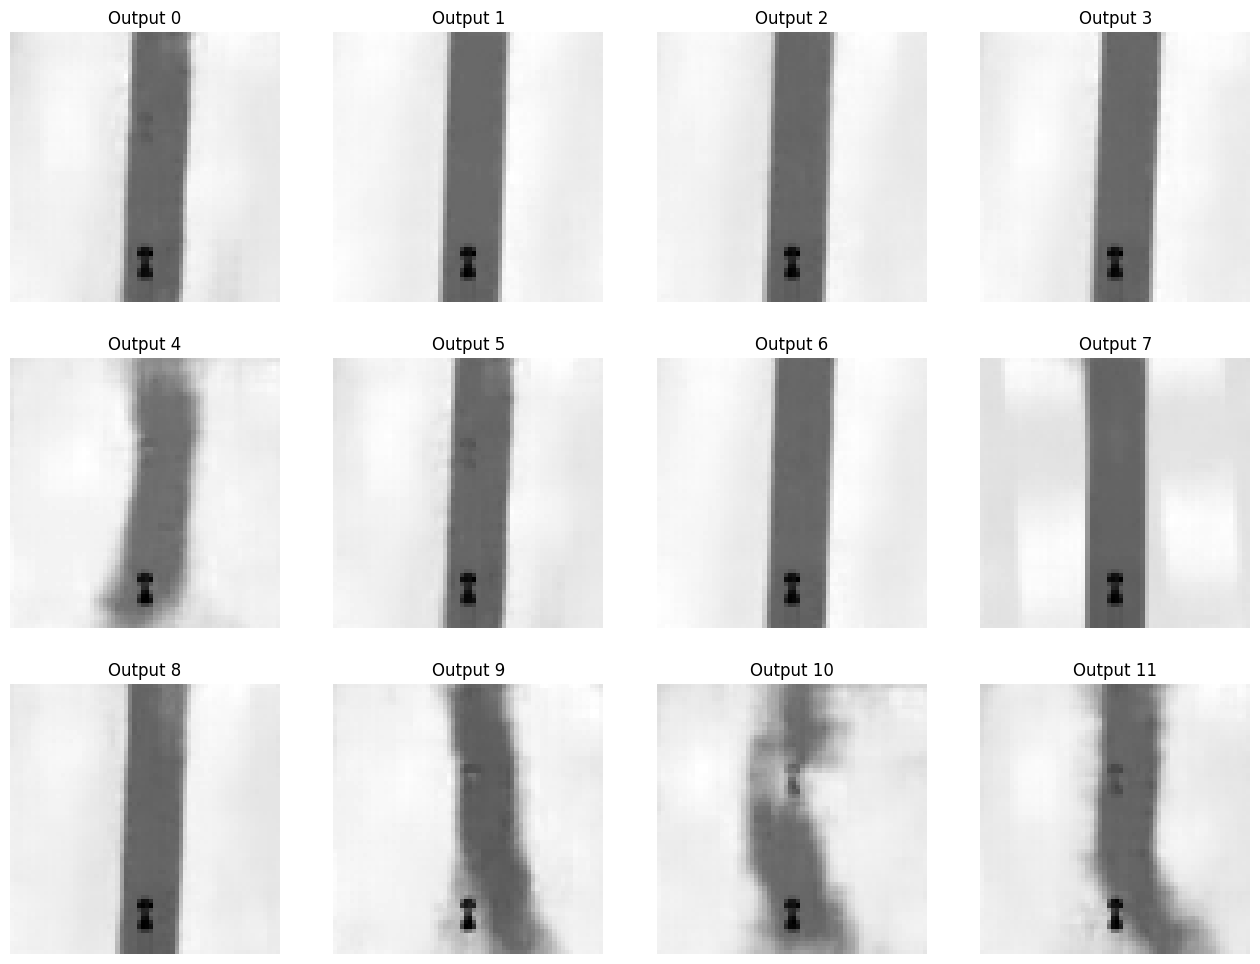

In [64]:
obs = trajs['observations'][0][64]


neighboors = generate_neighboring_latents(encoding_model, obs, n=11, epsilon=0.3)
neighboors = [torch.moveaxis(recon[0], 0, -1).detach().numpy() for recon in neighboors]
display_decoded_outputs(neighboors)

In [39]:
obs = trajs['observations'][0]
obs.shape

(297, 96, 96, 3)